In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import hera_pspec as hp
from pyuvdata import UVData
from scipy import stats
from statsmodels.stats import weightstats as stests

In [3]:
# Load beam model
beamfile = 'HERA_NF_dipole_power.beamfits'
cosmo = hp.conversions.Cosmo_Conversions()
uvb = hp.pspecbeam.PSpecBeamUV(beamfile, cosmo=cosmo)

# Load data into UVData objects
dfile = 'zen.2458116.34176.xx.HH.uvOCRS'
uvd = UVData()
uvd.read_miriad(dfile)

In [2]:
# We only have 1 data file here, so slide the time axis by one integration 
# to avoid noise bias (not normally needed!)
uvd1 = uvd.select(times=np.unique(uvd.time_array)[:-1:2], inplace=False)
uvd2 = uvd.select(times=np.unique(uvd.time_array)[1::2], inplace=False)

# Create a new PSpecData object
ds = hp.PSpecData(dsets=[uvd1, uvd2], wgts=[None, None], beam=uvb)
ds.rephase_to_dset(0) # Phase to the zeroth dataset

## Construct list of baseline pairs to calculate power spectra for
# bls = [(66, 67), (83, 84)]
# bls1, bls2, blp = hp.utils.construct_blpairs(bls, exclude_permutations=False, exclude_auto_bls=True)

## Power spectrum calculation
# uvp = ds.pspec(bls1, bls2, (0, 1), [('xx', 'xx')], spw_ranges=[(300, 400), (410, 819)], input_data_weight='identity', norm='I', 
#                taper='blackman-harris', verbose=False)

In [110]:
# Specify which baselines to include
baselines = [(66, 67), (83, 84), (82, 120)]

# Define uvp
uvp = ds.pspec(baselines, baselines, (0, 1), [('xx', 'xx')], spw_ranges=[(300, 400), (500, 600)],  input_data_weight='identity',
               norm='I', taper='blackman-harris', verbose=True) 



Setting spectral range: (300, 400)

Using polarization pair: ('xx', 'xx')

(bl1, bl2) pair: ((66, 67), (66, 67))
pol: (-5, -5)
 which may lead to normalization instabilities.
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((83, 84), (83, 84))
pol: (-5, -5)
 which may lead to normalization instabilities.
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((82, 120), (82, 120))
pol: (-5, -5)
 which may lead to normalization instabilities.
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

Setting spectral range: (500, 600)

Using polarization pair: ('xx', 'xx')

(bl1, bl2) pair: ((66, 67), (66, 67))
pol: (-5, -5)
 which may lead to normalization instabilities.
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((83, 84), (83, 84))
pol: (-5, -5)

Text(0.5, 1.0, 'spw : 1, blpair : ((83, 84), (83, 84)), pol : xx')

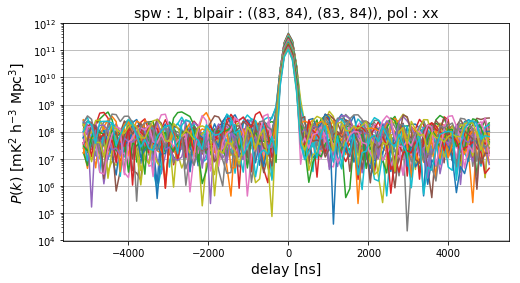

In [192]:
# without cable reflection
spw = 1
blp = ((83, 84), (83, 84))
# blp = ((82, 120), (82, 120))
key = (spw, blp, 'xx')
dlys = uvp.get_dlys(spw) * 1e9
power_wo = np.abs(np.real(uvp.get_data(key)))

# plot power spectrum of spectral window 1
fig, ax = plt.subplots(figsize=(8,4))
p1 = ax.plot(dlys, power_wo.T)
ax.set_yscale('log')
ax.grid()
ax.set_xlabel("delay [ns]", fontsize=14)
ax.set_ylabel(r"$P(k)\ \rm [mK^2\ h^{-3}\ Mpc^3]$", fontsize=14)
ax.set_title("spw : {}, blpair : {}, pol : {}".format(*key), fontsize=14)

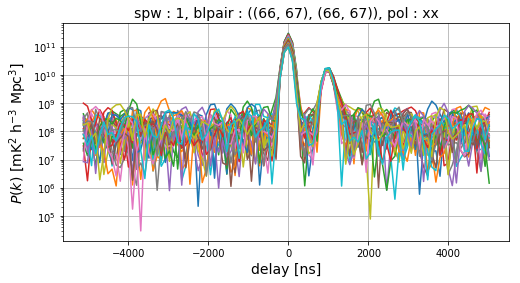

In [197]:
# with cable reflection
spw = 1
blp = ((66, 67), (66, 67))
# blp = ((82, 120), (82, 120))
key = (spw, blp, 'xx')
dlys = uvp.get_dlys(spw) * 1e9
power_w = np.abs(np.real(uvp.get_data(key)))

# plot power spectrum of spectral window 1
plt.figure(figsize=(8,4))
plt.semilogy(dlys, power_w.T)
plt.grid()
plt.xlabel("delay [ns]", fontsize=14)
plt.ylabel(r"$P(k)\ \rm [mK^2\ h^{-3}\ Mpc^3]$", fontsize=14)
plt.title("spw : {}, blpair : {}, pol : {}".format(*key), fontsize=14)
plt.show()

In [198]:
dly = [-5000, 5000]
dly_rg = 200

h0 = []
h1 = []
x = []
for i in range(int((dly[-1]-dly[0])/dly_rg)):
    dly_modes = [dly[0]+dly_rg*i, dly[0]+dly_rg*(i+1)]
    dly_idx = [(np.abs(dlys - dly_modes[0])).argmin(), (np.abs(dlys - dly_modes[1])).argmin()]
    x.append(int((dly[0]+dly_rg*i+dly[0]+dly_rg*(i+1))/2))
    # get data in delay mode domain
    data_wo = power_wo[:][:,dly_idx[0]:dly_idx[1]]
    data_w = power_w[:][:,dly_idx[0]:dly_idx[1]]

    pval = {}
    for i in range(len(data_wo)):
        pval[i] = stests.ztest(data_wo[i], data_w[i], value=0, alternative='two-sided')[1]

    z_stats = list(pval.values())
    
    a = 0
    for j in range(len(z_stats)):
        if z_stats[j] < 0.05:
            a += 1
    h0.append(a)
    h1.append(len(z_stats)-a)

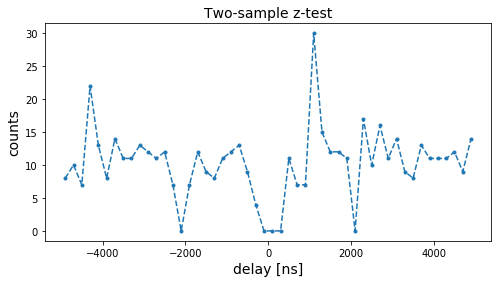

In [199]:
plt.figure(figsize=(8,4))
plt.plot(x, h0, '.--')
plt.title('Two-sample z-test', fontsize=14)
plt.xlabel('delay [ns]', fontsize=14)
plt.ylabel('counts', fontsize=14)
plt.show()